# Basic Network Analysis

`Date: 26/12/2019`

`Author: James Smith`

In this notebook we will do some basic preprocessing and network visualisation/analysis. Currently we have a standard tablular dataset with independent rows. Thus, in order to do this we will need to think about how we want to represent it as a network. 

## Summary

- [This article](https://www.analyticsvidhya.com/blog/2018/04/introduction-to-graph-theory-network-analysis-python-codes/) is very useful for a quick overview of network analytics. 
- [This article](https://medium.com/@nikkisharma536/knowledge-graph-part-2-modelling-tabular-data-as-graph-cfe1e0ee18fe) goes into more detail on modelling tabular data as a graph.
    > Nodes represent important entities/subjects/objects in our graphs. By having multiple types of node we can take advantage of the connected nature of the graph. For example : if our data set contains data about user and places with some metadata/attributes about both, we will create nodes for User and Place, and connect these by some Relation/edge (eg. User LIVES-IN Place) .

## Identifying Nodes

### Seller (Seller ID)
(if phone numbers are available this would be better - perhaps there are several seller ID's per phone number).

**Node Attributes**
- Seller name
- Number of ads seller has
- Seller location (possibly a separate node)
- Seller registration date
- Seller type

### Ad (Ad ID)

**Node Attributes**
- Ad info

### Location
(county and town concatenated)

Ideally we would like more specific location like full address to create meaningfull links, but we will leave this in as a demonstration

**Node Attributes**
- None

Load Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

table_location = r"C:\Users\User\Documents\ITB Year 2\Text Analytics and Web Content Mining\Assignments\Assignment 3\github\DoneDeal_Analytics\data\ad_info_table.csv"

ad_info_table = pd.read_csv(table_location)

In [2]:
len(ad_info_table)

10007

## Quick Cleaning

We only are looking at Private Sellers and excluding rows with missing data that we will value later on.

In [48]:
# Only want Private Sellers and those with actual IDs and location
num_rows_original = len(ad_info_table)

data = ad_info_table

data = data[data["seller_type"] == "PRIVATE"]
# data = data.drop(indexNames, inplace = True)

data = data.dropna(subset = ['ad_id','seller_county', 'seller_county_town', 'seller_id'])

# Ad location column
data["seller_location"] = data["seller_county_town"] + ", " + data["seller_county"]

num_rows_clean = len(data)

print(str(num_rows_original-num_rows_clean), "rows removed")

#data = data.sample(frac = 0.005)

4269 rows removed


In [49]:
len(data)

5738

# Representing Pandas Dataframe as Network

**Networkx**

- `from_pandas_dataframe()` - https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.convert_matrix.from_pandas_dataframe.html
    - Needs to be fed an edge list representation of a graph
    
- `g.add_edges_from()` 
    - Ads list of edges to an empty graph
    
    
## Sellers also need to be connected to a location!!!!

## Simple Example and Plot

### List attributes as connections to all ads

In [24]:
data.columns

Index(['Unnamed: 0', 'ad_age', 'ad_currency', 'ad_description', 'ad_header',
       'ad_id', 'ad_price', 'ad_url', 'car_body_type', 'car_colour',
       'car_engine', 'car_fuel_type', 'car_make', 'car_mileage', 'car_model',
       'car_nct_expiry', 'car_num_doors', 'car_num_prev_owners',
       'car_reg_country', 'car_road_tax', 'car_transmission', 'car_year',
       'green_light_verified', 'seller_county', 'seller_county_town',
       'seller_id', 'seller_name', 'seller_num_ads', 'seller_phone_number',
       'seller_reg_date', 'seller_type', 'seller_location'],
      dtype='object')

In [25]:
import matplotlib.pyplot as plt
import networkx as nx

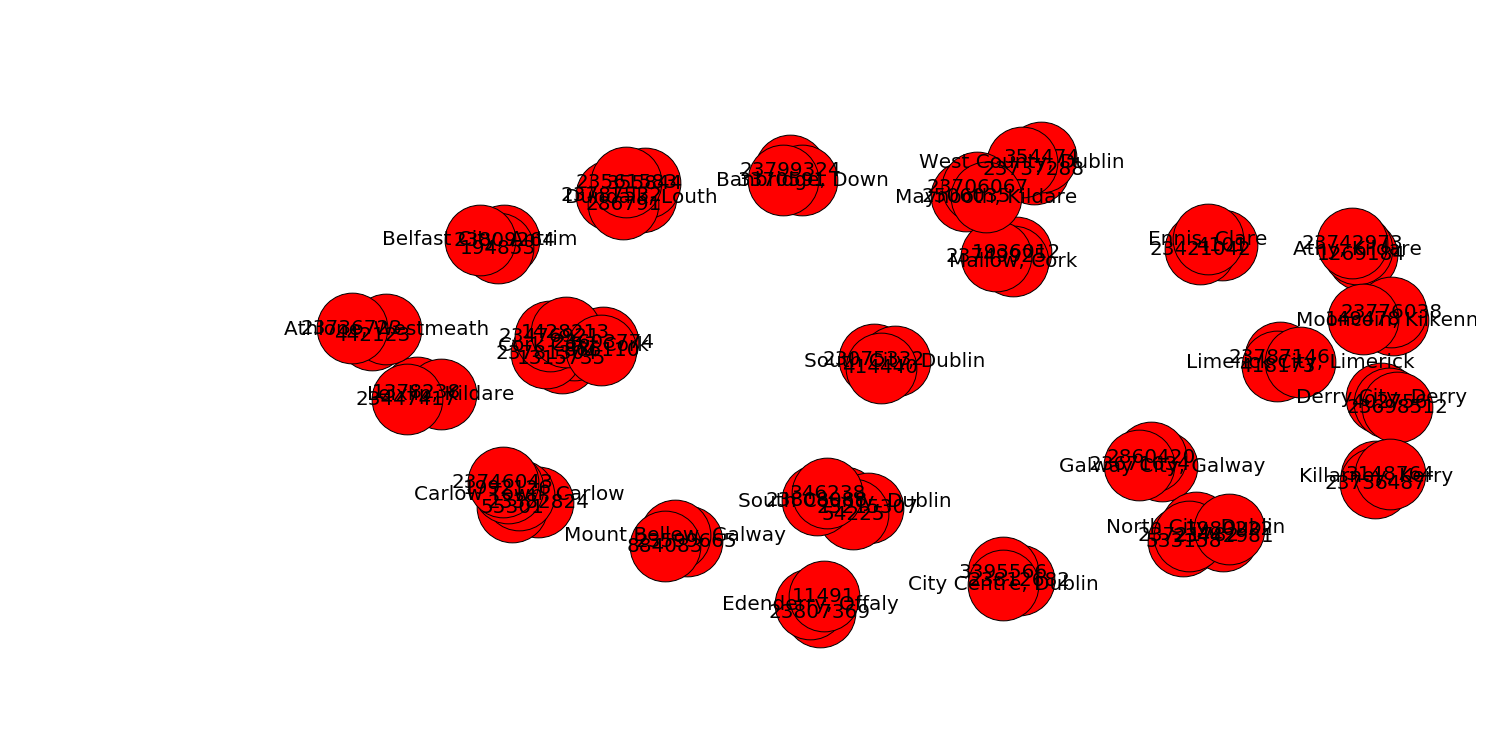

In [46]:
# Taken from https://codepunk.io/building-relationship-graphs-in-python-with-networkx/

#----- Get Nodes of Graph -----#

# Define what we want to make nodes
node_types = ["ad_id", "seller_location", "seller_id"]

# Dictionary of node_types and the list of them
nodes_list_dict = {node_type : list(data[node_type].unique()) for node_type in node_types}

# Format nodes as a list of tuples with the node and a dictionary
nodes = []
for node_type in node_types:
    nodes_list = nodes_list_dict[node_type]
    # Have list of specfic nodes for given type, loop over and append
    for node in nodes_list:
        nodes.append((node, {'node_type' : node_type}))
        
        
# Get all unique ads in the data frame
# ad_id_list = data["ad_id"].unique().tolist()


#---- Get Edges of Graph -----#

# Initialize list of edges
edges = []

for ad_id in nodes_list_dict['ad_id']:
    
    # Get a 1 row dataframe for specific ad
    ad = data[data["ad_id"] == ad_id]

    # Could think of an automated way of doing this using combinatorics
    edges.append((ad_id, ad['seller_location'].values[0]))
    edges.append((ad_id, ad['seller_id'].values[0]))
    edges.append((ad['seller_location'].values[0], ad['seller_id'].values[0]))
    

g = nx.Graph()
g.add_nodes_from(nodes)
g.add_edges_from(edges)

if len(data) < 300:
    # Plot
    plt.figure(figsize = (20, 10))

    nx.draw(g, with_labels = True, node_size = 5000, font_size = 20)  
    plt.show() 

## Network Analysis

In [35]:
def top_n_important_nodes(g, node_type, n, metric = 'degree_centrality'):
    """
    Function to get the top n most important node based on selected
    measure and node type
    """
    
    if metric == 'degree_centrality':
        d = nx.degree_centrality(g)
    elif metric == 'betweenness_centrality':
        d = nx.betweenness_centrality(g)
    else:
        print("Please choose a different metric")

    limit = 0
    top_dict = {}

    for k in sorted(d, key = d.get, reverse = True):
        if k in nodes_list_dict[node_type] and limit <= n - 1:
            top_dict[k] = round(d[k], 8)
            limit = limit + 1
    
    return top_dict

In [36]:
top_n_important_nodes(g, 'seller_location', 5, metric = 'degree_centrality')

{'Cork City, Cork': 0.03261,
 'North City, Dublin': 0.04818,
 'North County, Dublin': 0.04069,
 'South City, Dublin': 0.05124,
 'South County, Dublin': 0.05202}

In [37]:
top_n_important_nodes(g, 'seller_location', 5, metric = 'betweenness_centrality')

{'Cork City, Cork': 0.00106,
 'North City, Dublin': 0.00231,
 'North County, Dublin': 0.00165,
 'South City, Dublin': 0.00261,
 'South County, Dublin': 0.00269}

In [38]:
top_n_important_nodes(g, 'seller_id', 5, metric = 'degree_centrality')

{194602: 0.00128,
 354474: 0.00187,
 696364: 0.00168,
 1165124: 0.00168,
 1905202: 0.00404}

In [39]:
top_n_important_nodes(g, 'seller_id', 5, metric = 'betweenness_centrality')

{194602: 0.0, 354474: 0.0, 696364: 0.0, 1165124: 0.0, 1905202: 1e-05}

## Trying to Create a Nicer Visualisation

Inspired by [this article](http://jonathansoma.com/lede/algorithms-2017/classes/networks/networkx-graphs-from-source-target-dataframe/)

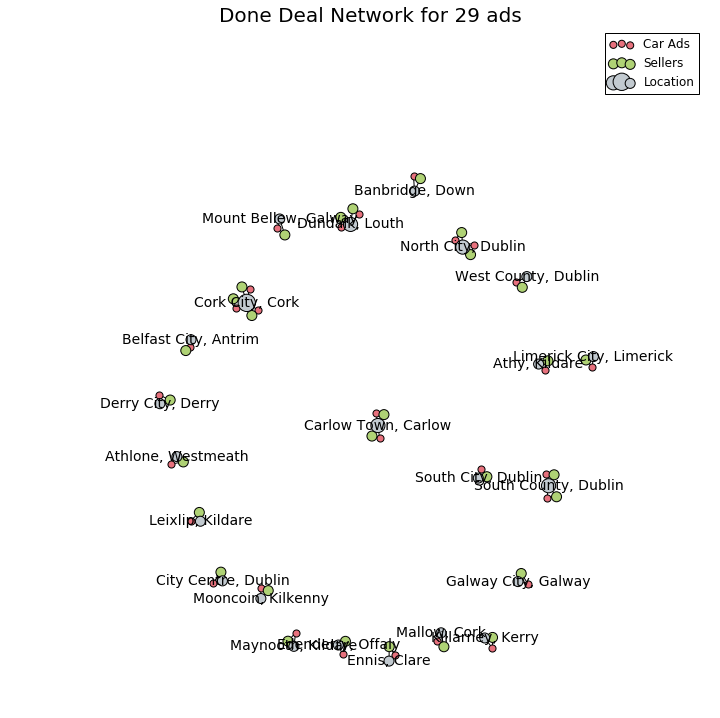

In [47]:
if len(data) < 300:
    #----- Define Layout -----# 

    plt.figure(figsize=(12, 12))
    layout = nx.spring_layout(g,iterations=50)

    #----- Set up colours -----#

    # Taken from num 11 on https://visme.co/blog/website-color-schemes/
    pallet = ['#E7717D', '#AFD275', '#C2CAD0', '#7E685A']

    #----- Set up node dictionary and sizes -----#

    # Get a corresponding dictionary of node sizes based on its degree
    node_sizes_dict = {}
    for node_type in node_types:
        node_type_sizes = [g.degree(node_type) * 50 for node_type in nodes_list_dict[node_type]]
        node_sizes_dict[node_type] = node_type_sizes

    #----- Draw nodes and edges -----#

    # ad_id - doesn't have sizes
    nx.draw_networkx_nodes(g, 
                           layout, 
                           nodelist = nodes_list_dict['ad_id'], 
                           # node_size = node_sizes_dict['ad_id'],
                           node_size = 50,
                           node_color = pallet[0], 
                           label = 'Car Ads')

    # seller_id
    nx.draw_networkx_nodes(g, 
                           layout, 
                           nodelist = nodes_list_dict['seller_id'], 
                           node_size = node_sizes_dict['seller_id'], 
                           node_color = pallet[1], 
                           label = 'Sellers')

    # seller_location
    nx.draw_networkx_nodes(g, 
                           layout, 
                           nodelist = nodes_list_dict['seller_location'], 
                           node_size = node_sizes_dict['seller_location'], 
                           node_color = pallet[2], 
                           label = 'Location')

    nx.draw_networkx_edges(g, layout, width = 1)
    #nx.draw_networkx_edges(g, layout, width = 1, edge_color = pallet[3])

    #----- Draw Labels -----#

    node_labels = dict(zip(nodes_list_dict['seller_location'], nodes_list_dict['seller_location']))
    nx.draw_networkx_labels(g, layout, labels = node_labels, font_size = 14)

    # 4. Turn off the axis because I know you don't want it
    plt.axis('off')
    plt.legend(numpoints = 1)

    title = "Done Deal Network for " + str(len(data)) + " ads"
    plt.title(title, fontsize = 20)

    # 5. Tell matplotlib to show it
    plt.show()
    
else:
    print("Too many data points to plot!")

In [ ]:
# g.edges(data = True)

Things to note:
- It would be better to have the **ads on the outside**
- Seller connectedness proportional to size
- Edge colour different for more important people
- Labels on those who are important sellers
- Choose more appealing colours
- Considering exporting to Gephi
- Consider having as multidirectional graph (**might help with drawing issues**)
- Consider
- Map to a map of Ireland